# Generate image caption

In [1]:
import pandas as pd

from tqdm.notebook import tqdm_notebook

from PIL import Image

import torch
from transformers import VisionEncoderDecoderModel, ViTFeatureExtractor, AutoTokenizer

import warnings

tqdm_notebook.pandas()
warnings.filterwarnings("ignore")

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Доступные GPU устройства: {torch.cuda.device_count()}")
    print(f"Используемое GPU устройство: {torch.cuda.get_device_name()}")

else:
    print("Доступных GPU нет")
    device = torch.device("cpu")

Доступные GPU устройства: 1
Используемое GPU устройство: NVIDIA GeForce RTX 3070 Ti


In [3]:
GPT_MODEL = "tuman/vit-rugpt2-image-captioning"

In [4]:
model = VisionEncoderDecoderModel.from_pretrained(GPT_MODEL)
feature_extractor = ViTFeatureExtractor.from_pretrained(GPT_MODEL)
tokenizer = AutoTokenizer.from_pretrained(GPT_MODEL)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [5]:
model.to(device)

VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0): ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, 

In [6]:
def predict_caption(image_paths):
    images = []
    for image_path in image_paths:
        i_image = Image.open(image_path)
        if i_image.mode != "RGB":
            i_image = i_image.convert(mode="RGB")

        images.append(i_image)

    pixel_values = feature_extractor(images=images, return_tensors="pt").pixel_values
    pixel_values = pixel_values.to(device)

    output_ids = model.generate(pixel_values)

    preds = tokenizer.batch_decode(output_ids, skip_special_tokens=True)
    preds = [pred.strip() for pred in preds]
    return preds

In [7]:
image_info_df = pd.read_csv("image_sentiment_data.csv")
image_info_df.head()

,image_path,sentiment
0,data/preprocess_images/positive/104505632.jpg,positive
1,data/preprocess_images/positive/1059249846.jpg,positive
2,data/preprocess_images/positive/108501238.jpg,positive
3,data/preprocess_images/positive/1089046474.jpg,positive
4,data/preprocess_images/positive/1096822187.jpg,positive


In [8]:
image_info_df["caption"] = image_info_df["image_path"].progress_apply(lambda path: predict_caption([path])[0])

  0%|          | 0/3255 [00:00<?, ?it/s]

In [9]:
import re

import nltk
from nltk.corpus import stopwords
from pymystem3 import Mystem

LANGUAGE = "russian"
nltk.download('stopwords')
lang_stopwords = set(stopwords.words(LANGUAGE))
mystem = Mystem()


def clean_text(sentence: str) -> str:
    """Clean text."""
    letters_only = re.sub("[^а-яА-ЯёЁ]", " ", sentence)
    lowercase_text = letters_only.lower()
    words = lowercase_text.split()
    lemmatize_words = [
        mystem.lemmatize(word)[0] for word in words
        if word not in lang_stopwords
    ]
    processes_string = " ".join(lemmatize_words)
    return processes_string

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dmitry\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
image_info_df["clean_caption"] = image_info_df["caption"].progress_apply(clean_text)

  0%|          | 0/3255 [00:00<?, ?it/s]

In [11]:
image_info_df.head()

,image_path,sentiment,caption,clean_caption
0,data/preprocess_images/positive/104505632.jpg,positive,"Женщина разговаривает по мобильному телефону, ...",женщина разговаривать мобильный телефон держат...
1,data/preprocess_images/positive/1059249846.jpg,positive,Женщина сидит на скамейке в парке с зонтиком.,женщина сидеть скамейка парк зонтик
2,data/preprocess_images/positive/108501238.jpg,positive,Женщина в очках и с длинными волосами держит м...,женщина очки длинный волос держать мобильный т...
3,data/preprocess_images/positive/1089046474.jpg,positive,Вид на город с высоты птичьего полета.,вид город высота птичий полет
4,data/preprocess_images/positive/1096822187.jpg,positive,Мужчина и женщина позируют фотографу.,мужчина женщина позировать фотограф


In [12]:
image_info_df.to_csv("image_sentiment_data_with_captions.csv", index=False)

(-0.5, 255.5, 255.5, -0.5)

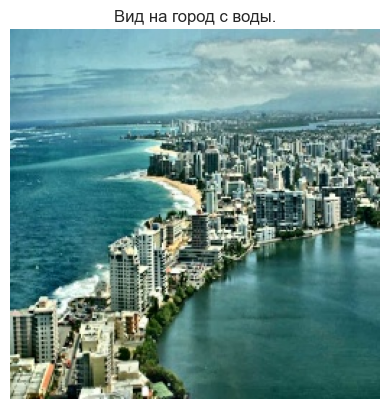

In [13]:
import cv2
import matplotlib.pyplot as plt


example = image_info_df.loc[10]
plt.title(example.caption)
plt.imshow(cv2.cvtColor(cv2.imread(example.image_path), cv2.COLOR_BGR2RGB))
plt.axis("off")